# Bayesian Regression

(Example from https://pyro.ai/examples/bayesian_regression.html the dataset is not working! So use https://www.kaggle.com/datasets/budincsevity/szeged-weather/data)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from time import time

torch.set_default_dtype(torch.float64)

/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
def optimize(params_dict, loss_function, y, cfg):
    optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=1)

    total_start = time()

    for i in range(500):

        optimizer.zero_grad()  # Reset gradients
        
        # loss
        current_dist = start_SOGA(cfg, params_dict)

        loss = loss_function(y, current_dist)

        # Backpropagate
        loss.backward(retain_graph=True)
        
        optimizer.step()

        # Print progress
        if i % 10 == 0:
            out = ''
            for key in params_dict.keys():
                out = out + key + ': ' + str(params_dict[key].item()) + ' '
            out = out + f" loss: {loss.item()}"
            print(out)

    total_end = time()

    print('Optimization performed in ', round(total_end-total_start, 3))

### Linear regression (not Bayesian)

We are given a dataset $D = {(X_i, y_i)}$.

The goal of linear regression is to fit a function of the form: $$y = wX+b+\epsilon$$

where $w$ and $b$ are learnable parameters and $\epsilon$ observation noise.

Text(0.5, 1.0, 'Humidity vs Apparent Temperature')

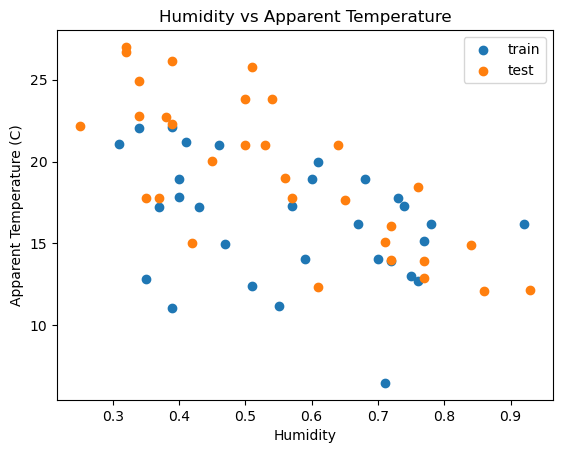

In [36]:
'''
Import the dataset
'''

weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = "train")
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"],label = "test")
plt.legend()
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Humidity vs Apparent Temperature")

In [41]:
X = torch.tensor(data["Humidity"].to_numpy())
y = torch.tensor(data["Apparent Temperature (C)"].to_numpy())

print(X)


tensor([0.4300, 0.7100, 0.5100, 0.4700, 0.3700, 0.7500, 0.3900, 0.5500, 0.7600,
        0.6700, 0.7000, 0.4000, 0.7200, 0.4600, 0.6800, 0.6100, 0.9200, 0.7800,
        0.6000, 0.3100, 0.3900, 0.7400, 0.4000, 0.7300, 0.3400, 0.7700, 0.5900,
        0.5700, 0.4100, 0.3500])


In [49]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Case Studies/linear_regression.soga')
cfg = produce_cfg(compiledFile)

pars = {'w':-5., 'b':10.}

params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

output_dist = start_SOGA(cfg, params_dict)

In [50]:
def mean_squared_error(y_true, dist):
    return torch.mean((y_true - dist.gm.mean()) ** 2)

In [51]:
optimize(params_dict, mean_squared_error, y, cfg)

w: -4.000000000974376 b: 10.999999999453816  loss: 95.59987242798351
w: 2.6807782615537192 b: 18.01372039209362  loss: 23.25461781642349
w: -0.3248466771068405 b: 16.004087311427135  loss: 13.305686189044518
w: -1.3774024210819997 b: 16.07902834494114  loss: 14.334811983088908
w: -1.0450004937940147 b: 17.603598198061388  loss: 13.436251546325302
w: -2.613557479239252 b: 17.27286655730318  loss: 12.58445689307931
w: -3.003794007133701 b: 18.08454309448731  loss: 12.233726928935871
w: -3.8389723031055287 b: 18.39572699796175  loss: 12.045087391030117
w: -4.499507146076728 b: 18.793621904490948  loss: 11.903465819158436
w: -5.0782225967636725 b: 19.170165075428944  loss: 11.794703375599289
w: -5.634278143352663 b: 19.458496464578474  loss: 11.71516047532265
w: -6.077958901227513 b: 19.74571207574609  loss: 11.659375315775522
w: -6.479529650652698 b: 19.965566658398078  loss: 11.621577420812212
w: -6.801471856974662 b: 20.162174256150177  loss: 11.596771417845302
w: -7.0711655169456105 b: